<a href="https://colab.research.google.com/github/bpezzullo/UrbanSoundClassificationUsingML/blob/main/Colab%20Notebooks/Experiment%202/train_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.1'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/

In [ ]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2020-11-12 15:41:47--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  1.04MB/s    in 0.8s    

2020-11-12 15:41:49 (1.04 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [ ]:
# Function to pull the files from my S3 drive.  I also stored the files under Github
import numpy as np
from google.colab import files
import json
# Read in data from S3 Buckets
from pyspark import SparkFiles

def pulljsonFiles(filename):
  json_url="https://billdatavizclass.s3.amazonaws.com/" + filename
  spark.sparkContext.addFile(json_url)
  data= spark.read.option('multiline','true').json(SparkFiles.get(filename))

  # return the data from the file
  inputsTmp = data.select("mfcc").collect()
  inputs = inputsTmp[0][0] #  
  targetsTmp = data.select("classID").collect()
  targets = targetsTmp[0][0]

  return inputs,targets



In [ ]:
def createSet(inputs,targets,currentSet=[], currentTarget=[]):

  for i in range(len(inputs)):
      currentSet.append(inputs[i])
      currentTarget.append(targets[i])
  return currentSet, currentTarget

In [ ]:
# This cell creates the input to the model and splits the data to Test, Validation, and Training.  In each model ran
# there will be 7 data sets (ds) of training data, 2 ds of test and 1 ds of validation giving the 70-10-20 split.  TO control this 
# modify the testList and valList with the approporiate datasets.  
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

fileList = ["data1.json","data2.json","data3.json","data4.json","data5.json","data6.json","data7.json","data8.json","data9.json","data10.json"]
testList = ["data10.json","data2.json"]
valList = ["data1.json"]
X_test = []
X_train = []
X_val = []
y_test = []
y_train = []
y_val = []

# loop through and create the input for the mode to run
for file in fileList:
  inputs, targets = pulljsonFiles(file)
  print(np.shape(inputs))
  if file in testList: X_test, y_test = createSet(inputs,targets,X_test, y_test)
  elif file in valList: x_val, y_val = createSet(inputs,targets,X_val, y_val)
  else: X_train, y_train = createSet(inputs,targets,X_train, y_train)
  print(f"done with file: {file}")
print("shape",np.shape(X_train))
print("shape",np.shape(X_test))
X_test = np.array(X_test)
X_train = np.array(X_train)
y_test = np.array(y_test)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

(3106, 44, 13)
done with file: data1.json
(3076, 44, 13)
done with file: data2.json
(3337, 44, 13)
done with file: data3.json
(3454, 44, 13)
done with file: data4.json
(3248, 44, 13)
done with file: data5.json
(2901, 44, 13)
done with file: data6.json
(3010, 44, 13)
done with file: data7.json
(2809, 44, 13)
done with file: data8.json
(2910, 44, 13)
done with file: data9.json
(2974, 44, 13)
done with file: data10.json
shape (21669, 44, 13)
shape (6050, 44, 13)


In [ ]:
# A visual of the shape and size of the data
print(X_train.shape[0],X_train.shape[1], X_train.shape[2])
print(y_train.shape[0], y_train.shape[1])
print(X_test.shape[0],X_test.shape[1], X_test.shape[2])
print(y_test.shape[0], y_test.shape[1])


21669 44 13
21669 1
6050 44 13
6050 1


In [ ]:
# mount google drive to save the results
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# This cell drives the creation and training of the models.  
from sklearn.metrics import classification_report
  
class_names=["air_conditioner",
             "car_horn",
             "children_playing",
             "dog_bark",
             "drilling",
             "engine_idling",
             "gun_shot",
             "jackhammer",
             "siren",
             "street_music"]


# Set the parameters for Sequential model
neuronsHidden = [2**6, 2**7, 2**8, 2**9]
dropouts = [0.2, 0.3, 0.4]
epochs = [30, 40, 50]
batchsizes = [16, 32]
finalResults = []
save_model = False
# When narrowing down on the best model, created the below array and modified the for statement to below.
# sets = [[128,0.4,150,16],[128,0.4,200,16]]

sets = [[128,0.4,150,16]]
save_model = True
for (nn,dd,ee,bb) in sets:     # this replaces the 4 for statements below

# for nn in neuronsHidden:
#   for dd in dropouts:
#     for ee in epochs:
#       for bb in batchsizes:
        data = run_model(nn,dd,ee,bb,X_train,y_train,X_test,y_test,X_val,y_val,save_model)
        finalResults.append(data)
        # plot_history2(data)    # if you wanted to plot the training and validation lines uncomment
        print(nn,dd,ee,bb)

# file name is based on the dataset being used.
# test one was ds 1, 3 for test and 2 for validate  resultsds123.json
# test two was ds 4, 6 for test and 5 for validate  resultsds456.json
# test one was ds 7, 9 for test and 8 for validate  resultsds789.json
# test two was ds 10, 2 for test and 1 for validate resultsds1012.json

with open("/content/gdrive/My Drive/FinalProject/resultsds123.json", "w") as f:
  json.dump(finalResults, f)

files.download("/content/gdrive/My Drive/FinalProject/resultsds123.json")

128 0.4 150 16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def run_model(nn,dd,ee,bb,X_train,y_train,X_test,y_test,X_val,y_val,save_model):
  param_results = {"parameters": [],
                  "report" : [],
                  "finalAcc": 0.0,
                  "finalVal": 0.0,
                  "finalAccData": [],
                  "finalValData": []
                  }
  class_names=["air_conditioner",
             "car_horn",
             "children_playing",
             "dog_bark",
             "drilling",
             "engine_idling",
             "gun_shot",
             "jackhammer",
             "siren",
             "street_music"]

  keras.backend.clear_session()


  # build the network architecture
  model = keras.Sequential([
      # input layer
      keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
      
      # lst hidden layer
      keras.layers.Dense(nn, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.Dropout(dd),
      
      # 2nd hidden layer
      keras.layers.Dense(nn/2, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.Dropout(dd),
      
      # # 3rd hidden layer
      keras.layers.Dense(nn/4, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.Dropout(dd),
      
      # output layer
      keras.layers.Dense(10, activation="softmax")
  ])

  # compile network : example
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer,   # 'adam',
              loss = "sparse_categorical_crossentropy",
              metrics=["accuracy"])

  model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ee, batch_size=bb, verbose=0 )
              
  # store the result which will be later saved to a file            
  predictions = np.argmax(model.predict(X_test), axis=1)
  report = classification_report(y_test, predictions,
                                  target_names=class_names,
                                  output_dict=True)
  param_results["parameters"]= [nn,dd,ee,bb],
  param_results["report"] = report
  param_results["finalAcc"]= model_history.history["accuracy"][-1]
  param_results["finalVal"]= model_history.history["val_accuracy"][-1]
  param_results["finalAccData"]= model_history.history["accuracy"]
  param_results["finalValData"]= model_history.history["val_accuracy"]
  
  if save_model: 
    # Save the model to be used later
    model.save("/content/gdrive/My Drive/FinalProject/Experiment2_best_model.h5")

  return param_results

In [ ]:
import matplotlib.pyplot as plt

def plot_history2(history):
  fig, axs = plt.subplots(1,figsize=(20,10))

  # create the accuracy subplot
  axs[0].plot(history["history"]["accuracy"],label="train accuracy")
  axs[0].plot(history["history"]["val_accuracy"],label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="best")
  axs[0].set_title("accuracy eval")
  axs[0].set_ylim(0, 1)

  plt.show()

#Re-run model

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
voice_model = load_model("/content/gdrive/My Drive/FinalProject/Experiment2_best_model.h5")

In [ ]:
model_loss, model_accuracy = model.evaluate(
    X_test, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Calculate classification report
class_names=["air_conditioner",
              "car_horn",
             "children_playing",
             "dog_bark",
             "drilling",
             "engine_idling",
             "gun_shot",
             "jackhammer",
             "siren",
             "street_music"]
# convert output to simple array
y_temp = []
for i in range(len(y_test)):
  y_temp.append(y_test[i][0])

             
from sklearn.metrics import classification_report
predictions = model.predict_classes(X_test)
print(classification_report(y_temp, predictions,
                            target_names=class_names))

# Single run cells


In [ ]:
# After selecting the best model, I took scaled the input to see if that would improve the results.  In this case it made
# it worse.
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
scalers = {}
X_train_scaled = X_train
X_test_scaled = X_test
X_val_scaled = X_val

for i in range(X_train.shape[1]):
  scalers[i]= StandardScaler()
  X_train_scaled[:,i,:] = scalers[i].fit_transform(X_train[:,i,:])

for i in range(X_test.shape[1]):
  X_test_scaled[:,i,:] = scalers[i].transform(X_test[:,i,:])

for i in range(X_val.shape[1]):
  X_val_scaled[:,i,:] = scalers[i].transform(X_val[:,i,:])
# X_scaler = MinMaxScaler().fit(X_train)


In [ ]:
print("scaled",X_test_scaled[0][0])
print('reg',X_test[0][0])

scaled [-2.32965262 -0.91503091 -1.22064651 -2.46677326 -0.04863221 -1.85756005
 -1.3626175  -0.93088443  0.17465882  2.10449883  4.30238814  1.85625286
  0.22116921]
reg [-2.32965262 -0.91503091 -1.22064651 -2.46677326 -0.04863221 -1.85756005
 -1.3626175  -0.93088443  0.17465882  2.10449883  4.30238814  1.85625286
  0.22116921]


In [ ]:
# Clear out the previous results so they don't taint the next run.
keras.backend.clear_session()

In [ ]:
# Cells used to learn about the models and just run single runs.
# build the network architecture
model = keras.Sequential([
    # input layer
    keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # lst hidden layer
    keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.4),
    
    # 2nd hidden layer
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.4),
    
    # # 3rd hidden layer
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.4),
    
    # output layer
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
# compile network : example
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,   # 'adam',
             loss = "sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 572)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               73344     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

# Train the model

In [ ]:
# train network
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)



Epoch 1/50
1355/1355 [==============================] - 3s 2ms/step - loss: 13.7610 - accuracy: 0.1380 - val_loss: 2.6672 - val_accuracy: 0.1610
Epoch 2/50
1355/1355 [==============================] - 3s 2ms/step - loss: 2.8883 - accuracy: 0.1522 - val_loss: 2.6002 - val_accuracy: 0.1771
Epoch 3/50
1355/1355 [==============================] - 3s 2ms/step - loss: 2.6616 - accuracy: 0.1490 - val_loss: 2.5331 - val_accuracy: 0.1668
Epoch 4/50
1355/1355 [==============================] - 3s 2ms/step - loss: 2.5812 - accuracy: 0.1534 - val_loss: 2.5156 - val_accuracy: 0.1655
Epoch 5/50
1355/1355 [==============================] - 3s 2ms/step - loss: 2.5196 - accuracy: 0.1568 - val_loss: 2.4793 - val_accuracy: 0.1703
Epoch 6/50
1355/1355 [==============================] - 3s 2ms/step - loss: 2.4897 - accuracy: 0.1628 - val_loss: 2.4475 - val_accuracy: 0.1922
Epoch 7/50
1355/1355 [==============================] - 3s 2ms/step - loss: 2.4427 - accuracy: 0.1885 - val_loss: 2.3600 - val_accuracy

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history,figname):
  fig, axs = plt.subplots(2,figsize=(20,10))

  # create the accuracy subplot
  axs[0].plot(history.history["accuracy"],label="train accuracy")
  axs[0].plot(history.history["val_accuracy"],label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="best")
  axs[0].set_title("accuracy eval")
  axs[0].set_ylim(0, 1)

  # create error subplot
  axs[1].plot(history.history["loss"],label="train error")
  axs[1].plot(history.history["val_loss"],label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="best")
  axs[1].set_title("Error eval")
  # axs[1].set_ylim(0, 1)

  fig.savefig(figname)

  plt.show()

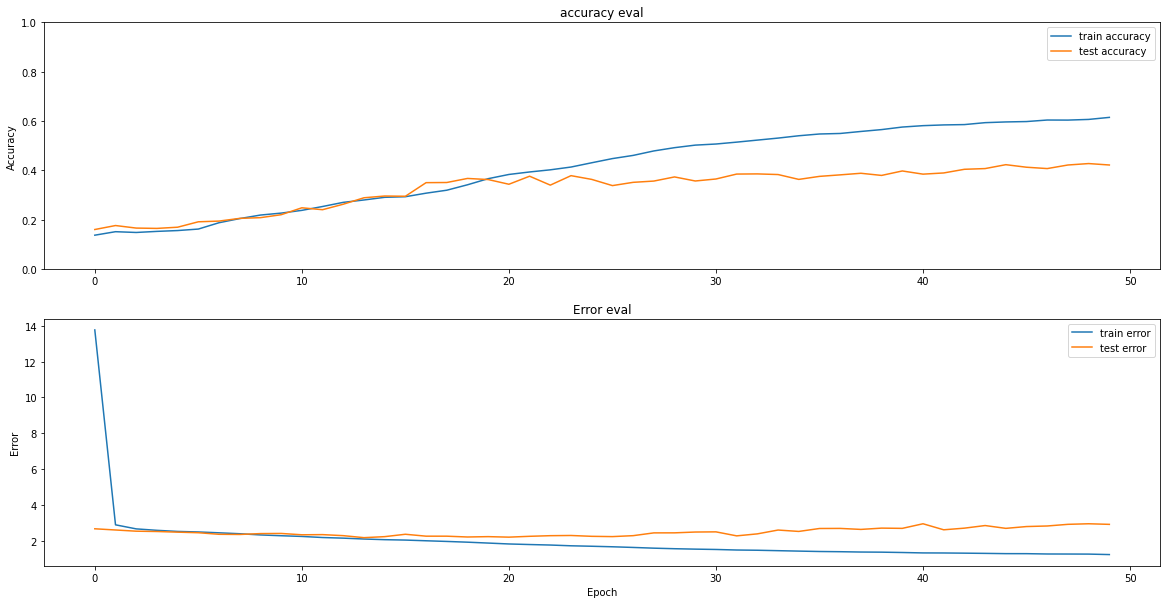

In [ ]:
plot_history(model_history,'neuron128(of).png')

In [25]:
print(model_history.history["accuracy"][-1])
print(model_history.history["val_accuracy"][-1])

0.6147953271865845
0.42208629846572876


In [26]:
# Save the model
model.save("sound_model1.h5")

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
voice_model = load_model("sound_model_trained.h5")

In [ ]:
model_loss, model_accuracy = model.evaluate(
    X_test, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

210/210 - 0s - loss: 11.1195 - accuracy: 0.4115
Normal Neural Network - Loss: 11.119521141052246, Accuracy: 0.41151896119117737


In [ ]:
# Calculate classification report
class_names=["air_conditioner",
              "car_horn",
             "children_playing",
             "dog_bark",
             "drilling",
             "engine_idling",
             "gun_shot",
             "jackhammer",
             "siren",
             "street_music"]
# convert output to simple array
y_temp = []
for i in range(len(y_test)):
  y_temp.append(y_test[i][0])

             
from sklearn.metrics import classification_report
predictions = model.predict_classes(X_test)
print(classification_report(y_temp, predictions,
                            target_names=class_names))

                  precision    recall  f1-score   support

 air_conditioner       0.34      0.13      0.19       798
        car_horn       0.34      0.25      0.29       473
children_playing       0.28      0.40      0.33       786
        dog_bark       0.42      0.61      0.49       594
        drilling       0.30      0.28      0.29       664
   engine_idling       0.62      0.34      0.44       832
        gun_shot       0.80      0.71      0.75        90
      jackhammer       0.60      0.43      0.50       762
           siren       0.69      0.62      0.66       903
    street_music       0.28      0.56      0.38       800

        accuracy                           0.41      6702
       macro avg       0.47      0.43      0.43      6702
    weighted avg       0.45      0.41      0.41      6702



In [ ]:
import pandas as pd

df = pd.DataFrame({'Prediction':predictions.tolist(),
              'Actual': y_temp}
             )


df.head()
df.to_csv('neurons128.csv')

In [ ]:
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train, y_train)

[2, 2, 2, 2, 4, 4, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 8, 0, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 0, 0, 0, 0, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 0, 4, 3, 9, 9, 0, 0, 2, 2, 9, 3, 9, 9, 8, 3, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 6, 6, 6, 6, 6, 6, 9, 6, 6, 9, 6, 6, 6, 6, 6, 9, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 2, 3, 2, 3, 4, 3, 4, 3, 3, 3, 3, 

classID:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music